# SIN CURVE PREDICTION

In [1]:
import random

from tqdm import tqdm as tq
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class SineEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SineEncoder, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.lstm = nn.LSTM(input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=1,
                    batch_first=False,
                    bidirectional=False)
        
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), 
                torch.zeros(1, 1, self.hidden_size, device=device))
        
    def forward(self, input_tensor, hidden_tensor):
        output_tensor, hidden_tensor = self.lstm(input_tensor, hidden_tensor)
        return hidden_tensor

In [3]:
class SineDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SineDecoder, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.lstm = nn.LSTM(input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=1,
                    batch_first=False,
                    bidirectional=False)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor, hidden_tensor):
        output_tensor, hidden_tensor = self.lstm(input_tensor, hidden_tensor)
        output_tensor = self.linear(output_tensor)
        output_tensor = torch.tanh(output_tensor)
        return output_tensor, hidden_tensor

In [4]:
checkpoint = torch.load("/kaggle/input/sin-curve-train/checkpoint.pth")

In [5]:
encoder = SineEncoder(1, 128).to(device)
decoder = SineDecoder(1, 128, 1).to(device)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

optim_encoder = checkpoint['optim_encoder']
optim_decoder = checkpoint['optim_decoder']

encoder.eval()
decoder.eval()

SineDecoder(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
def get_sample(nos, div):
    start = random.randint(0,100)
    step = .05
    ticks = torch.arange(start=start, end=start+nos*step, step=step, device=device)
    sins = torch.sin(ticks)
    
    X = sins[:div]
    Y = sins[div:]
    
    return X.view(-1,1,1,1),Y,ticks.view(-1)

In [7]:
def sample_result(nos, ratio):
    div = int(nos * max(.1, min(.9, ratio)))
#     print(div)
#     div = 25
    X,Y,ticks = get_sample(nos, div)
    hidden_tensor = encoder.init_hidden()

    for x in X:
        hidden_tensor = encoder.forward(x, hidden_tensor)
    
    kk = 0
    Y_pred = []
    output_tensor = X[-1]
    for i in range(Y.shape[0]):
        output_tensor, hidden_tensor = decoder.forward(output_tensor, hidden_tensor)
        Y_pred.append(output_tensor.view(-1)[0].item())
        
    y_ticks_first = X.view(-1).cpu().detach().numpy()
    y_ticks_next = Y.cpu().detach().numpy()
    y_ticks_pred = np.array(Y_pred)
    xticks = 180 / math.pi * ticks.cpu().detach().numpy()
    
    plt.scatter(xticks[:div],y_ticks_first)
#     plt.scatter(xticks[div:],y_ticks_next)
    plt.scatter(xticks[div:],y_ticks_pred)
    plt.show()

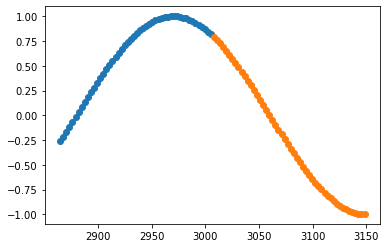

In [8]:
sample_result(100, .5)

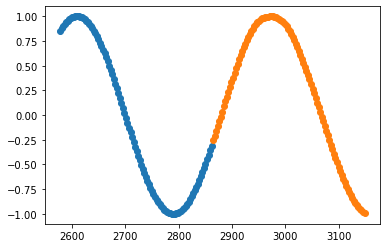

In [9]:
sample_result(200, .5)

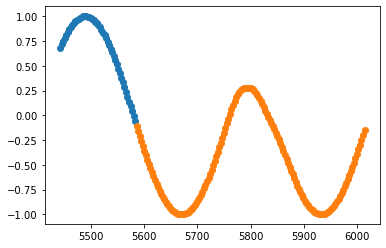

In [10]:
sample_result(200, .25)